In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

num_steps = 100
batch_size = 64

def read_data(normal_logs, abnormal_logs):
    data, labels = [], []
    rep = 1
    for filepath in normal_logs:
        with open(filepath) as fp:
            for line in fp:
                content = line.replace('\n', '')
                for _ in range(rep):
                    data.append(content)
                    labels.append(0)

    for filepath in abnormal_logs:
        with open(filepath) as fp:
            for line in fp:
                content = line.replace('\n', '')
                for _ in range(rep):
                    data.append(content)
                    labels.append(1)

    return data, labels

train_data = read_data(["./filter/ceph-dout-filter.txt", "./filter/glustrefs_info-filter.txt", "./filter/daos-debug-filter.txt","./filter/orangefs-debug-filter.txt"], ["./filter/ceph-derr-filter.txt", "./filter/glustrefs_error-filter.txt", "./filter/daos-error-filter.txt", "./filter/orangefs-error-filter.txt"])

test_data = read_data(["./filter/lustre-debug-filter.txt"], ["./filter/lustre-error-filter.txt"])

train_tokens = d2l.tokenize(train_data[0], token='word')
test_tokens = d2l.tokenize(test_data[0], token='word')

vocab = d2l.Vocab(train_tokens, min_freq=2, reserved_tokens=['<pad>'])
train_features = torch.tensor([
        d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
        for line in train_tokens])
test_features = torch.tensor([
        d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
        for line in test_tokens])

train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size, is_train=False)

In [2]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional recurrent neural
        # network
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (no. of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # nn.LSTM, both h_0 and c_0 default to zero.
        # we only use the hidden states of the last hidden layer
        # at different time step (outputs). The shape of `outputs` is
        # (no. of words, batch size, 2 * no. of hidden units).
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

net.apply(init_weights)

BiRNN(
  (embedding): Embedding(3808, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [3]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False


loss 0.163, train acc 0.940, test acc 0.764
49.1 examples/sec on [device(type='cpu')]


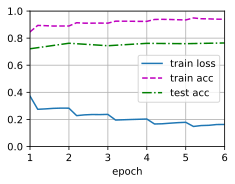

In [4]:
lr, num_epochs = 0.01, 6
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


In [5]:
#@save
def predict_sentiment(net, vocab, sentence):
    sentence = torch.tensor(vocab[sentence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sentence.reshape(1, -1)), dim=1)
    return label.item()

In [6]:
#predict_sentiment(net, vocab, 'cw req compare fail')
predict_sentiment(net, vocab, 'extend list usable nics')

0

In [7]:
lustre_test_data = read_data(["./filter/lustre-actual-log-debug-filter"], ["./filter/lustre-actual-log-error-filter"])
print(lustre_test_data[0][0], lustre_test_data[1][0])

lustre ost transno commit 0


In [8]:
beegfs_test_data = read_data(["./filter/beegfs-actual-log-debug-filter"], ["./filter/beegfs-actual-log-error-filter"])
def test(name, data_for_test):
    right = 0
    TruePositives = 0
    FalsePositives = 0
    FalseNegatives = 0
    TrueNegatives = 0
    total = 0
    for i in range(0, len(data_for_test[0])):
        text = data_for_test[0][i]
        label = data_for_test[1][i]
        #if (len(text.split()) > 2):
        total += 1
        if total % 10000 == 0:
            print("....handle", total, "lines already...")

        t = torch.tensor(vocab[text.split()], device=d2l.try_gpu())
        l = torch.argmax(net(t.reshape(1, -1)), dim=1)
        l = l.item()
        
        if l == 1 and label == 1:
            TruePositives += 1
            #print("TruePositives", text, label, l)
        if l == 1 and label == 0:
            FalsePositives += 1
            #print("FalsePositives", text, label, l)
        if l == 0 and label == 1:
            FalseNegatives += 1
            #print("FalseNegatives", text, label, l)
        if l == 0 and label == 0:
            TrueNegatives += 1
        
        if l == label:
            right += 1

    precision = (TruePositives)/(TruePositives+FalsePositives)
    recall = (TruePositives)/(TruePositives+FalseNegatives)
    f = (2 * precision * recall) / (precision + recall)
    print (name, right, total, "Accuracy:", (right)/(total), "Precision:", precision, "Recall:", recall, "F-Measure:", f)

test("beegfs", beegfs_test_data)
#test("lustre", lustre_test_data)

beegfs 131 158 Accuracy: 0.8291139240506329 Precision: 0.5909090909090909 Recall: 1.0 F-Measure: 0.7428571428571429


In [19]:
test("lustre", read_data(["./lustre-debug-filter.txt"], ["./lustre-error-filter.txt"]))
test("orangefs", read_data(["./orangefs-debug-filter.txt"], ["./orangefs-error-filter.txt"]))
test("daos", read_data(["./daos-debug-filter.txt"], ["./daos-error-filter.txt"]))
test("ceph", read_data(["./ceph-dout-filter.txt"], ["./ceph-derr-filter.txt"]))
test("glustrefs", read_data(["./glustrefs_info-filter.txt"], ["./glustrefs_error-filter.txt"]))

lustre 4733 5296 0.8936933534743202
orangefs 2009 2260 0.8889380530973451
daos 4612 4993 0.9236931704386141
ceph 16644 18242 0.9123999561451596
glustrefs 7068 7720 0.9155440414507772


In [44]:
test("beegfs", beegfs_test_data)

beegfs 145 158 Accuracy: 0.9177215189873418 Precision: 0.7708333333333334 Recall: 0.9487179487179487 F-Measure: 0.8505747126436781
